In [1]:
import time
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.feature_selection import RFECV

from sklearn.linear_model import LinearRegression,GammaRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
import lightgbm as lgb

In [2]:
# 分析データに関する設定
SEED = 100 #これを基本的に使用
# SEED = 202120971 # #これを基本的に使用（自分の学籍番号）

## データ準備

In [5]:
# 1. データの読み込み
###### 633 nm ######
wavelen = 633

# 補正後のprofile特徴量
feature_First_df = pd.read_csv(f'./../data/data_FirstStorage/data_laser_1condition/feature/feature_CB_HDR/feature_shake/{wavelen}nm/feature_all.csv',index_col=0)
feature_Second_df = pd.read_csv(f'./../data/data_SecondStorage/data_laser_1condition/feature/feature_CB_HDR/feature_shake/{wavelen}nm/feature_all.csv',index_col=0)
feature_df_633 = pd.concat([feature_First_df, feature_Second_df],axis=0)
# 特徴量の結合
feature_df_633.columns = [f'{col}_{wavelen}' for col in feature_df_633.columns]

###### 850 nm ######
wavelen = 850

# 補正後のprofile特徴量
feature_First_df = pd.read_csv(f'./../data/data_FirstStorage/data_laser_1condition/feature/feature_CB_HDR//feature_shake/{wavelen}nm/feature_all.csv',index_col=0)
feature_Second_df = pd.read_csv(f'./../data/data_SecondStorage/data_laser_1condition/feature/feature_CB_HDR//feature_shake/{wavelen}nm/feature_all.csv',index_col=0)
feature_df_850 = pd.concat([feature_First_df, feature_Second_df],axis=0)
# 特徴量の結合
feature_df_850.columns = [f'{col}_{wavelen}' for col in feature_df_850.columns]

##### 目的変数 #####
target_First_df = pd.read_csv(f'./../data/data_FirstStorage/data_mealiness_shake/Mealiness.csv',index_col=0)
target_First_df = target_First_df.iloc[:feature_First_df.shape[0],0].astype(float) #初期状態が文字列だったので，小数に変換
target_Second_df = pd.read_csv(f'./../data/data_SecondStorage/data_mealiness_shake/Mealiness.csv',index_col=0)
target_Second_df = target_Second_df.iloc[:feature_Second_df.shape[0],0].astype(float) #初期状態が文字列だったので，小数に変換

target_df = pd.concat([target_First_df, target_Second_df],axis=0)
target_df.index = feature_df_633.index


###### 合成と削除 ######
feature_df = pd.concat([feature_df_633, feature_df_850],axis=1)

# 実験に失敗したサンプル2(Firststorage, 04_03_2)を削除
# 実験に失敗したサンプル2(Secondstorage, 04_08_4)を削除
target_df = target_df.dropna(axis=0)
feature_df = feature_df.reset_index()
target_df = target_df.reset_index()

target_df = target_df.drop(target_df.index[84],axis=0)
feature_df = feature_df.drop([feature_df.index[84],feature_df.index[195]],axis=0)

feature_df = feature_df.drop(['index'],axis=1)
target_df.index = target_df['index']
target_df = target_df.drop(['index'],axis=1)
feature_df.index = target_df.index

## データの標準化

In [6]:
# データの分割
# 各貯蔵期間の09, 10サンプルをtestに用いる
X_test = feature_df[feature_df.index.str.contains('9|10')]
X_train = feature_df.drop(X_test.index, axis=0)
y_test = target_df[target_df.index.str.contains('9|10')]
y_train = target_df.drop(y_test.index, axis=0)

# 標準化
scaler = StandardScaler()

X_train_scale = scaler.fit_transform(X_train)
X_train_scale = pd.DataFrame(X_train_scale,
                             columns = X_train.columns,
                             index = X_train.index)


X_test_scale = scaler.transform(X_test)
X_test_scale = pd.DataFrame(X_test_scale,
                             columns = X_test.columns,
                             index = X_test.index)


# # 標準化（粉質化）
# scaler = StandardScaler()

# y_train_scale = scaler.fit_transform(y_train)
# y_train = pd.DataFrame(y_train_scale,
#                        columns = y_train.columns,
#                        index = y_train.index)


# y_test_scale = scaler.transform(y_test)
# y_test = pd.DataFrame(y_test_scale,
#                       columns = y_test.columns,
#                       index = y_test.index)


## 変数選択

In [7]:
# 相関の確認
# abs(pd.concat([feature_df,target_df],axis=1).corr())['Mealiness (%)'].sort_values(ascending=False).head(40)
# plt.scatter(feature_df['Farrell_1_633'],target_df)

In [8]:
# trainデータで、mealinessと相関係数が0.1以上の変数のみ抽出
THRESH = 0.1
temp = abs(pd.concat([X_train_scale,y_train],axis=1).corr())['Mealiness (%)'][abs(pd.concat([X_train_scale, y_train],axis=1).corr())['Mealiness (%)'].sort_values(ascending=False)>THRESH].index
temp = temp.drop(['Mealiness (%)'])


X_train_scale = X_train_scale.loc[:,temp]
X_test_scale = X_test_scale.loc[:,temp]

print('特徴量の数',X_train_scale.shape[1],'個')

特徴量の数 188 個


In [22]:
kf_inner = KFold(n_splits=10, shuffle=True, random_state=100)

In [30]:
%%time

##### パラメータの設定 #####
# PLS
param_pls = {'n_components':[i for i in range(5,60)]}

# SVM
param_svm = {
    'C':[i/10 for i in range(201,601)],#201 
    'kernel':['rbf'],
    'gamma':[1e-1,1e-2,5e-2,1e-3,5e-3,1e-4,5e-4,1e-5,5e-5]
    # 
}

param_ann = {'hidden_layer_sizes':[(55,),(15,),(6,)],#(88,),(44,)
             'activation':['relu'],
             'solver':['adam'],
             'alpha':[100,10,1,1e-2],
             'batch_size':[50,100,150],
            }

##### GridSearch #####
# PLSのGridSearch 
CV_pls = GridSearchCV(
    PLSRegression(),
    param_pls,
    scoring='neg_mean_squared_error',
    cv=kf_inner,
    n_jobs = -1
)
# SVMのGridSearch
CV_svm = GridSearchCV(
    SVR(),
    param_svm,
    scoring='neg_mean_squared_error',
    cv=kf_inner,
    n_jobs=-1
)
# ANNのGridSearch
CV_ann = GridSearchCV(
    MLPRegressor(early_stopping=True,random_state=SEED),
    param_ann,
    scoring='neg_mean_squared_error',
    cv=kf_inner,
    n_jobs=-1
)


# GridSearchの結果表示
results_pls = CV_pls.fit(X_train_scale, y_train)
results_svm = CV_svm.fit(X_train_scale,y_train.values.ravel())
results_ann = CV_ann.fit(X_train_scale.values,y_train.values.ravel())

CPU times: user 5.99 s, sys: 507 ms, total: 6.5 s
Wall time: 21.5 s


In [31]:
print('Best Parameter of PLS')
print(results_pls.best_params_)
print()
print('Best Parameter of SVM')
print(results_svm.best_params_)
print()
print('Best Parameter of ANN')
print(results_ann.best_params_)
print()
# {'C': 18.8, 'gamma': 0.0005, 'kernel': 'rbf'}

Best Parameter of PLS
{'n_components': 5}

Best Parameter of SVM
{'C': 45.7, 'gamma': 0.0001, 'kernel': 'rbf'}

Best Parameter of ANN
{'activation': 'relu', 'alpha': 100, 'batch_size': 50, 'hidden_layer_sizes': (15,), 'solver': 'adam'}



In [32]:
%%time

###### 指定したハイパラでモデル構築 #####

# PLS
pls = PLSRegression(n_components=results_pls.best_params_['n_components'])
model_PLS = pls.fit(X_train_scale,y_train)

# SVM
svm = SVR(
    kernel='rbf',
    C=results_svm.best_params_['C'], 
    gamma=results_svm.best_params_['gamma']
)
model_SVM = svm.fit(X_train_scale, y_train)

# ANN
ann = MLPRegressor(hidden_layer_sizes=results_ann.best_params_['hidden_layer_sizes'],
                   activation=results_ann.best_params_['activation'],
                   solver=results_ann.best_params_['solver'],
                   alpha=results_ann.best_params_['alpha'],
                   batch_size=results_ann.best_params_['batch_size'],
                   random_state=SEED
                  )

model_ANN = ann.fit(X_train_scale, y_train)



##### モデルの予測 #####

# trainの予測
y_pred_train_ANN = model_ANN.predict(X_train_scale).flatten()
y_pred_train_SVM = model_SVM.predict(X_train_scale).flatten()
y_pred_train_PLS = model_PLS.predict(X_train_scale).flatten()

y_pred_train_SVM_PLS = np.mean([y_pred_train_SVM,y_pred_train_PLS],axis=0)
y_pred_train_ANN_SVM = np.mean([y_pred_train_ANN,y_pred_train_SVM],axis=0)
y_pred_train_ANN_PLS = np.mean([y_pred_train_ANN,y_pred_train_PLS],axis=0)
y_pred_train_ANN_SVM_PLS = np.mean([y_pred_train_ANN,y_pred_train_SVM, y_pred_train_PLS],axis=0)


# testの予測
y_pred_SVM = model_SVM.predict(X_test_scale).flatten()
y_pred_PLS = model_PLS.predict(X_test_scale).flatten()
y_pred_ANN = model_ANN.predict(X_test_scale).flatten()

y_pred_SVM_PLS = np.mean([y_pred_SVM,y_pred_PLS.flatten()],axis=0)
y_pred_ANN_SVM = np.mean([y_pred_ANN,y_pred_SVM],axis=0)
y_pred_ANN_PLS = np.mean([y_pred_ANN,y_pred_PLS],axis=0)
y_pred_ANN_SVM_PLS = np.mean([y_pred_ANN,y_pred_SVM_PLS],axis=0)

# weight averaging
# weightを求める
model_list = [model_PLS,model_SVM,model_ANN]
i_weight_sum = 0
i_weight_list = []
for i_model in model_list:
    i_model_pred = i_model.predict(X_train_scale).flatten()
    i_weight = 1/np.sqrt(mean_squared_error(y_train.values.flatten(),i_model_pred.flatten())) # errorの逆数
    i_weight_list.append(i_weight)
    i_weight_sum += i_weight

i_weight_array = np.array(i_weight_list)/i_weight_sum

y_pred_train_weight_3 = np.average([y_pred_train_ANN,y_pred_train_SVM, y_pred_train_PLS],weights=i_weight_array,axis=0)
y_pred_weight_3 = np.average([y_pred_ANN,y_pred_SVM, y_pred_PLS],weights=i_weight_array,axis=0)

CPU times: user 316 ms, sys: 191 ms, total: 507 ms
Wall time: 122 ms


In [33]:
%%time
##### Stacking #####

X_ensemble_train = pd.concat([
          pd.DataFrame(y_pred_train_PLS,columns=['PLS'],index=y_train.index),
          pd.DataFrame(y_pred_train_SVM,columns=['SVM'],index=y_train.index),
          pd.DataFrame(y_pred_train_ANN,columns=['ANN'],index=y_train.index),
          ],axis=1
         )

X_ensemble_test = pd.concat([
          pd.DataFrame(y_pred_PLS,columns=['PLS'],index=y_test.index),
          pd.DataFrame(y_pred_SVM,columns=['SVM'],index=y_test.index),
          pd.DataFrame(y_pred_ANN,columns=['ANN'],index=y_test.index),
          ],axis=1
         )

# # stacking (regression model : ANN)
# param_ann = {'hidden_layer_sizes':[2*i for i in range(1,25)],
#              'activation':['relu'],
#              'solver':['adam'],
#              'alpha':[200,100,50,10,1,1e-1,1e-2],
#              'batch_size':[50,100,150],
#             }

# # Stacking(ANNのGridSearch)
# CV_ann_stacking = GridSearchCV(
#     MLPRegressor(random_state=SEED),
#     param_ann,
#     cv=kf_inner,
#     n_jobs=-1
# )

# results_ann_stack = CV_ann_stacking.fit(X_ensemble_train.values,y_train.values.ravel())
# ann = MLPRegressor(hidden_layer_sizes=results_ann_stack.best_params_['hidden_layer_sizes'],
#                    activation=results_ann_stack.best_params_['activation'],
#                    solver=results_ann_stack.best_params_['solver'],
#                    alpha=results_ann_stack.best_params_['alpha'],
#                    batch_size=results_ann_stack.best_params_['batch_size'],
#                    random_state=SEED
#                   )

# model_ANN = ann.fit(X_ensemble_train.values, y_train.values.ravel())

# y_pred_train_stack = model_ANN.predict(X_ensemble_train)
# y_pred_stack = model_ANN.predict(X_ensemble_test)

# # 最適化の表示
# print('Best Parameter of ANN')
# print(results_ann_stack.best_params_)
# print()

# stacking (regression model : SVM)
param_svm = {
    'C':[i/10 for i in range(1,200)], 
    'kernel':['rbf'],
    'gamma':[100,10,1,1e-1,5e-1,1e-2,5e-2,1e-3,5e-3,1e-4,5e-4,1e-5,5e-5]
    # 200,150,100,50,10,5,1,
}

# Stacking(SVMのGridSearch)
CV_svm_stacking = GridSearchCV(
    SVR(),
    param_svm,
    cv=kf_inner,
    n_jobs=-1
)

results_svm_stack = CV_svm_stacking.fit(X_ensemble_train.values,y_train.values.ravel())
svm = SVR(C=results_svm_stack.best_params_['C'],
                   kernel=results_svm_stack.best_params_['kernel'],
                   gamma=results_svm_stack.best_params_['gamma'],
                   # alpha=results_ann_stack.best_params_['alpha'],
                   # batch_size=results_ann_stack.best_params_['batch_size'],
                   # random_state=SEED
                  )

model_SVM = svm.fit(X_ensemble_train.values, y_train.values.ravel())

y_pred_train_stack_svm = model_SVM.predict(X_ensemble_train)
y_pred_stack_svm = model_SVM.predict(X_ensemble_test)

# 最適化の表示
print('Best Parameter of Ensemble SVM')
print(results_svm_stack.best_params_)
print()

Best Parameter of Ensemble SVM
{'C': 19.9, 'gamma': 0.0005, 'kernel': 'rbf'}

CPU times: user 2.24 s, sys: 42.8 ms, total: 2.28 s
Wall time: 3.04 s


In [34]:
##### 精度評価 #####
# ５. 精度評価
RANGE = np.max(y_test)[0] - np.min(y_test)[0]

temp = pd.DataFrame([
    [
        np.corrcoef(y_train.values.flatten(),y_pred_train_SVM)[0][1], 
        np.corrcoef(y_train.values.flatten(),y_pred_train_PLS.flatten())[0][1],
        np.corrcoef(y_train.values.flatten(),y_pred_train_ANN.flatten())[0][1],
        np.corrcoef(y_train.values.flatten(),y_pred_train_ANN_SVM_PLS.flatten())[0][1],
        np.corrcoef(y_train.values.flatten(),y_pred_train_weight_3.flatten())[0][1],
        np.corrcoef(y_train.values.flatten(),y_pred_train_stack_svm.flatten())[0][1],
    ],

    [
        np.corrcoef(y_test.values.flatten(),y_pred_SVM)[0][1],
        np.corrcoef(y_test.values.flatten(),y_pred_PLS.flatten())[0][1],
        np.corrcoef(y_test.values.flatten(),y_pred_ANN.flatten())[0][1],
        np.corrcoef(y_test.values.flatten(),y_pred_ANN_SVM_PLS.flatten())[0][1],
        np.corrcoef(y_test.values.flatten(),y_pred_weight_3.flatten())[0][1],
        np.corrcoef(y_test.values.flatten(),y_pred_stack_svm.flatten())[0][1]
    ],

    [
        np.sqrt(mean_squared_error(y_train.values.flatten(),y_pred_train_SVM)),
        np.sqrt(mean_squared_error(y_train.values.flatten(),y_pred_train_PLS.flatten())),
        np.sqrt(mean_squared_error(y_train.values.flatten(),y_pred_train_ANN.flatten())),
        np.sqrt(mean_squared_error(y_train.values.flatten(),y_pred_train_ANN_SVM_PLS.flatten())),
        np.sqrt(mean_squared_error(y_train.values.flatten(),y_pred_train_weight_3.flatten())),
        np.sqrt(mean_squared_error(y_train.values.flatten(),y_pred_train_stack_svm.flatten())),
    ],

    [
        np.sqrt(mean_squared_error(y_test.values.flatten(),y_pred_SVM)),
        np.sqrt(mean_squared_error(y_test.values.flatten(),y_pred_PLS.flatten())),
        np.sqrt(mean_squared_error(y_test.values.flatten(),y_pred_ANN.flatten())),
        np.sqrt(mean_squared_error(y_test.values.flatten(),y_pred_ANN_SVM_PLS.flatten())),
        np.sqrt(mean_squared_error(y_test.values.flatten(),y_pred_weight_3.flatten())),
        np.sqrt(mean_squared_error(y_test.values.flatten(),y_pred_stack_svm.flatten()))
    ],

    [
        np.sqrt(1/(1 - np.corrcoef(y_test.values.flatten(),y_pred_SVM.flatten())[0][1]**2)),
        np.sqrt(1/(1 - np.corrcoef(y_test.values.flatten(),y_pred_PLS.flatten())[0][1]**2)),
        np.sqrt(1/(1 - np.corrcoef(y_test.values.flatten(),y_pred_ANN.flatten())[0][1]**2)),
        np.sqrt(1/(1 - np.corrcoef(y_test.values.flatten(),y_pred_ANN_SVM_PLS.flatten())[0][1]**2)),
        np.sqrt(1/(1 - np.corrcoef(y_test.values.flatten(),y_pred_weight_3.flatten())[0][1]**2)),
        np.sqrt(1/(1 - np.corrcoef(y_test.values.flatten(),y_pred_stack_svm.flatten())[0][1]**2))
    ],

    [
        RANGE/np.sqrt(mean_squared_error(y_test.values.flatten(),y_pred_SVM)),
        RANGE/np.sqrt(mean_squared_error(y_test.values.flatten(),y_pred_PLS.flatten())),
        RANGE/np.sqrt(mean_squared_error(y_test.values.flatten(),y_pred_ANN.flatten())),
        RANGE/np.sqrt(mean_squared_error(y_test.values.flatten(),y_pred_ANN_SVM_PLS.flatten())),
        RANGE/np.sqrt(mean_squared_error(y_test.values.flatten(),y_pred_weight_3.flatten())),
        RANGE/np.sqrt(mean_squared_error(y_test.values.flatten(),y_pred_stack_svm.flatten()))
    ],

    [
        100*2*np.sqrt(mean_squared_error(y_test.values.flatten(),y_pred_SVM))/RANGE,
        100*2*np.sqrt(mean_squared_error(y_test.values.flatten(),y_pred_PLS.flatten()))/RANGE,
        100*2*np.sqrt(mean_squared_error(y_test.values.flatten(),y_pred_ANN.flatten()))/RANGE,
        100*2*np.sqrt(mean_squared_error(y_test.values.flatten(),y_pred_ANN_SVM_PLS.flatten()))/RANGE,
        100*2*np.sqrt(mean_squared_error(y_test.values.flatten(),y_pred_weight_3.flatten()))/RANGE,
        100*2*np.sqrt(mean_squared_error(y_test.values.flatten(),y_pred_stack_svm.flatten()))/RANGE
    ],
])

temp.columns = ['SVM','PLS','ANN','Simple Ensemble','Weighted Ensemble','Stacking(SVM)']
temp.index = ['R_train','R_test','RMSE_train','RMSE_test','RPD_test','RER_test','EI_test']
temp = temp.T

temp

,R_train,R_test,RMSE_train,RMSE_test,RPD_test,RER_test,EI_test
SVM,0.495136,0.513199,8.240057,8.854075,1.165135,4.599675,43.481336
PLS,0.619098,-0.168745,7.138043,27187.608753,1.014549,0.001498,133515.188019
ANN,0.553045,-0.168060,7.792527,3923.536771,1.014428,0.010380,19268.033261
Simple Ensemble,0.614689,-0.168533,7.436293,8759.285041,1.014512,0.004649,43015.831211
Weighted Ensemble,0.615035,-0.168591,7.430258,10361.969520,1.014522,0.003930,50886.428495
Stacking(SVM),0.623272,0.493122,7.287610,8.944453,1.149478,4.553198,43.925171


## Stackingのyyplot

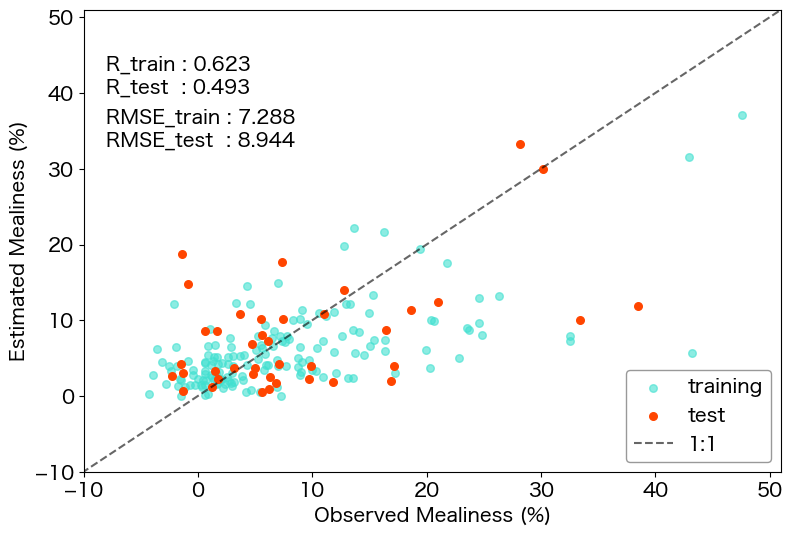

/Users/daiki/miniforge3/envs/tsukuba/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:621: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/Users/daiki/miniforge3/envs/tsukuba/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:621: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/Users/daiki/miniforge3/envs/tsukuba/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:621: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/Users/daiki/miniforge3/envs/tsukuba/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/daiki/miniforge3/envs/tsukuba/lib/python3.8

In [36]:
fig = plt.figure(figsize=(9,6))
plt.scatter(y_train,y_pred_train_stack_svm,c='turquoise',alpha=0.6,label='training',marker='.',s=120)
plt.scatter(y_test,y_pred_stack_svm,c='orangered',alpha=1,label='test',marker='.',s=120)
plt.plot([-100,100],[-100,100],c='k',linestyle='dashed',label='1:1',alpha=0.6)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Observed Mealiness (%)',fontsize=14)
plt.ylabel('Estimated Mealiness (%)',fontsize=14)
plt.xlim(int(target_df.min())-6,int(target_df.max())+4)
plt.ylim(int(target_df.min())-6,int(target_df.max())+4)

MODEL = 'Stacking(SVM)'
plt.text(-8,43,f"R_train : {temp.T[MODEL][0]:.3f}",fontsize=14)
plt.text(-8,40,f"R_test  : {temp.T[MODEL][1]:.3f}",fontsize=14)
plt.text(-8,36,f"RMSE_train : {temp.T[MODEL][2]:.3f}",fontsize=14)
plt.text(-8,33,f"RMSE_test  : {temp.T[MODEL][3]:.3f}",fontsize=14)

plt.legend(loc='lower right', fontsize=14, edgecolor='gray')
plt.show()

# fig.savefig(f'./../../something/yyplot_2wave_{MODEL}.png',dpi=360)
# fig.savefig('./../output/図_粉質化_yyplot.png',dpi=400)